In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 10)
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from scipy.sparse import hstack
import seaborn as sns
#from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from nltk.stem import SnowballStemmer
input_path = '/kaggle/input/sf-dst-car-price-prediction-part2/'
tf.__version__

'2.6.2'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5266184957748777956
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9402622476573074092
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2021-12-19 19:02:00.865494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-19 19:02:00.926437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:02:01.022104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:02:01.022798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [3]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## EDA & feature engineering

In [4]:
df = pd.read_csv(input_path + 'train.csv')
df['sample'] = 1
test = pd.read_csv(input_path + 'test.csv')
test['price'] = 0
test['sample'] = 0
data = test.append(df, sort=False).reset_index(drop=True)

print(df.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [5]:
# Нормализуем описания
snowball = SnowballStemmer(language='russian')

def normalize(s):
    try:
        return ' '.join([re.sub('[^а-яА-Я]+', '', snowball.stem(x)) for x in s.split()])
    except:
        return None

data['description_norm'] = data['description'].apply(normalize)

In [6]:
i=10
print(data['description'].iloc[i])
print('-'*100)
print(normalize(data['description'].iloc[i]))

Отрываю от сердца этого красавца. Да, он не в идеальном состоянии, но к сожалению у самого нет таких средств, чтобы заняться полным восстановлением. Поэтому решил отдать в хорошие руки, тем, кто сможет довезти до ума эту уникальную машину. 
Автомобиль БЕЗ права отчуждения!!! Возможно ездить по доверенности. В ПТС указано 150 л.с., по факту 231 л.с.
----------------------------------------------------------------------------------------------------
отрыва от сердц эт красавца да он не в идеальн состоянии но к сожален у сам нет так средств чтоб заня полн восстановлением поэт реш отда в хорош руки тем кто сможет довезт до ум эт уникальн машину автомобил без прав отчуждения возможн езд по доверенности в птс указа  лс по факт  лс


In [7]:
data[['description','description_norm']]

,description,description_norm
0,Всем привет!\n\nПродам эксклюзивный проект 124...,всем привет прод эксклюзивн проект универса ...
1,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,прода любим тачилу обвес и тюнинг пот что сов...
2,"Машина тут продаётся не в первый раз, НО! Толь...",машин тут прода не в перв раз но тольк что пер...
3,"Автомобиль в отличном состоянии, весь в родной...",автомобил в отличн состоянии ве в родн краск ...
4,Немка! с бесключивым доступом и камерой заднег...,немка с бесключив доступ и камер задн вида авт...
...,...,...
8348,Продаётся любимый автомобиль! За годы эксплуат...,прода любим автомобиль за год эксплуатац машин...
8349,Куплена у официального дилера в 2017 г. \n\nТр...,купл у официальн дилер в г трет владелец все ...
8350,Торг на месте. Все работает. Сборка немецкая. ...,торг на месте все работает сборк немецкая рези...
8351,Автомобиль в отличном состоянии.\n3-из Авто в ...,автомобил в отличн состоянии из авт в сем обс...


In [8]:
# Результаты из CV-ноутбука
CV_prediction = pd.read_csv('/kaggle/input/cars-cv-model/CV_model_predictions.csv')[['sell_id','train','CV_prediction']]

In [9]:
data = data.merge(CV_prediction, on ='sell_id')

In [10]:
# Заменяем длинные типичные объявления (в основном РОЛЬФ)
top_description = list(data.groupby('description')[['sell_id']].count().sort_values('sell_id', ascending = False).head(40).index)
top_description = {x : 'top_description_' + str(i) for (i,x) in enumerate(top_description)}
data['description'] = data['description'].replace(top_description)

In [11]:
def extract(s):
    try:
        return float(s.split()[0])
    except:
        return -1

def extract_ownership(s):
    try:
        return float(s.split()[0]) + float(s.split()[-2])/12
    except:
        return -1

data['log_price'] = np.log(data.price)
data['engineDisplacement_num'] = data['engineDisplacement'].apply(lambda s: extract(s))
data['enginePower_num'] = data['enginePower'].apply(lambda s: extract(s))
data['ownership'] = data['Владение'].apply(lambda s: extract_ownership(s))
data['description_length'] = data['description'].apply(lambda s: len(s))
data['description_words_count'] = data['description'].apply(lambda s: len(s.split()))

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'numberOfDoors'
            , 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']
num_cols = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement_num', 'enginePower_num', 'ownership', 'description_length', 'description_words_count']
data.sample(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,price,sample,description_norm,train,CV_prediction,log_price,engineDisplacement_num,enginePower_num,ownership,description_length,description_words_count
5561,седан,BMW,чёрный,"Авто нет даже года,без аварий,стояние новой ма...",2.0 LTR,184 N12,бензин,5000,2016,5ER,520i 2.0 AT (184 л.с.),4,2018,1099352264,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,2900000.0,1,авт нет даж годабез аварийстоян нов машиныочен...,1,15.182972,14.880221,2.0,184.0,-1.00,72,9
538,седан,BMW,коричневый,top_description_20,1.6 LTR,136 N12,бензин,104000,2011,3ER,316i 1.6 AT (136 л.с.),4,2013,1099737102,SEDAN AUTOMATIC 1.6,автоматическая,3 или более,NaN,Оригинал,задний,Левый,0.0,0,все автомобили представлен в продаже проход тщ...,1,13.230840,-inf,1.6,136.0,-1.00,18,1
7781,седан,BMW,серый,"Авто в идеальном состоянии. Ухожен , обслужен....",2.0 LTR,190 N12,дизель,42000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2018,1098909458,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,9 месяцев,Оригинал,полный,Левый,2400000.0,1,авт в идеальн состоянии ухож обслужен втор вл...,1,15.097422,14.690979,2.0,190.0,9.75,655,94
7479,внедорожник 5 дв.,AUDI,белый,Машина в идеальном состоянии. Полный S Line. С...,2.0 LTR,211 N12,бензин,148000,2008,Q5,8tiptronic 2.0 AT (211 л.с.) 4WD,5,2012,1097026176,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,полный,Левый,1050000.0,1,машин в идеальн состоянии полн спортивн пере...,1,14.075286,13.864301,2.0,211.0,-1.00,373,49
7406,внедорожник 5 дв.,MERCEDES,серый,НА ОБМЕН 2.750.000\nАвто в идеале ! Без окрасо...,2.0 LTR,381 N12,бензин,35000,2017,GLA_CLASS_AMG,45 AMG 2.0 AMT (381 л.с.) 4WD,5,2018,1099372128,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,2 владельца,NaN,Оригинал,полный,Левый,2340000.0,1,на обм авт в идеал без окрасов гот на люб пр...,0,14.885138,14.665661,2.0,381.0,-1.00,231,41


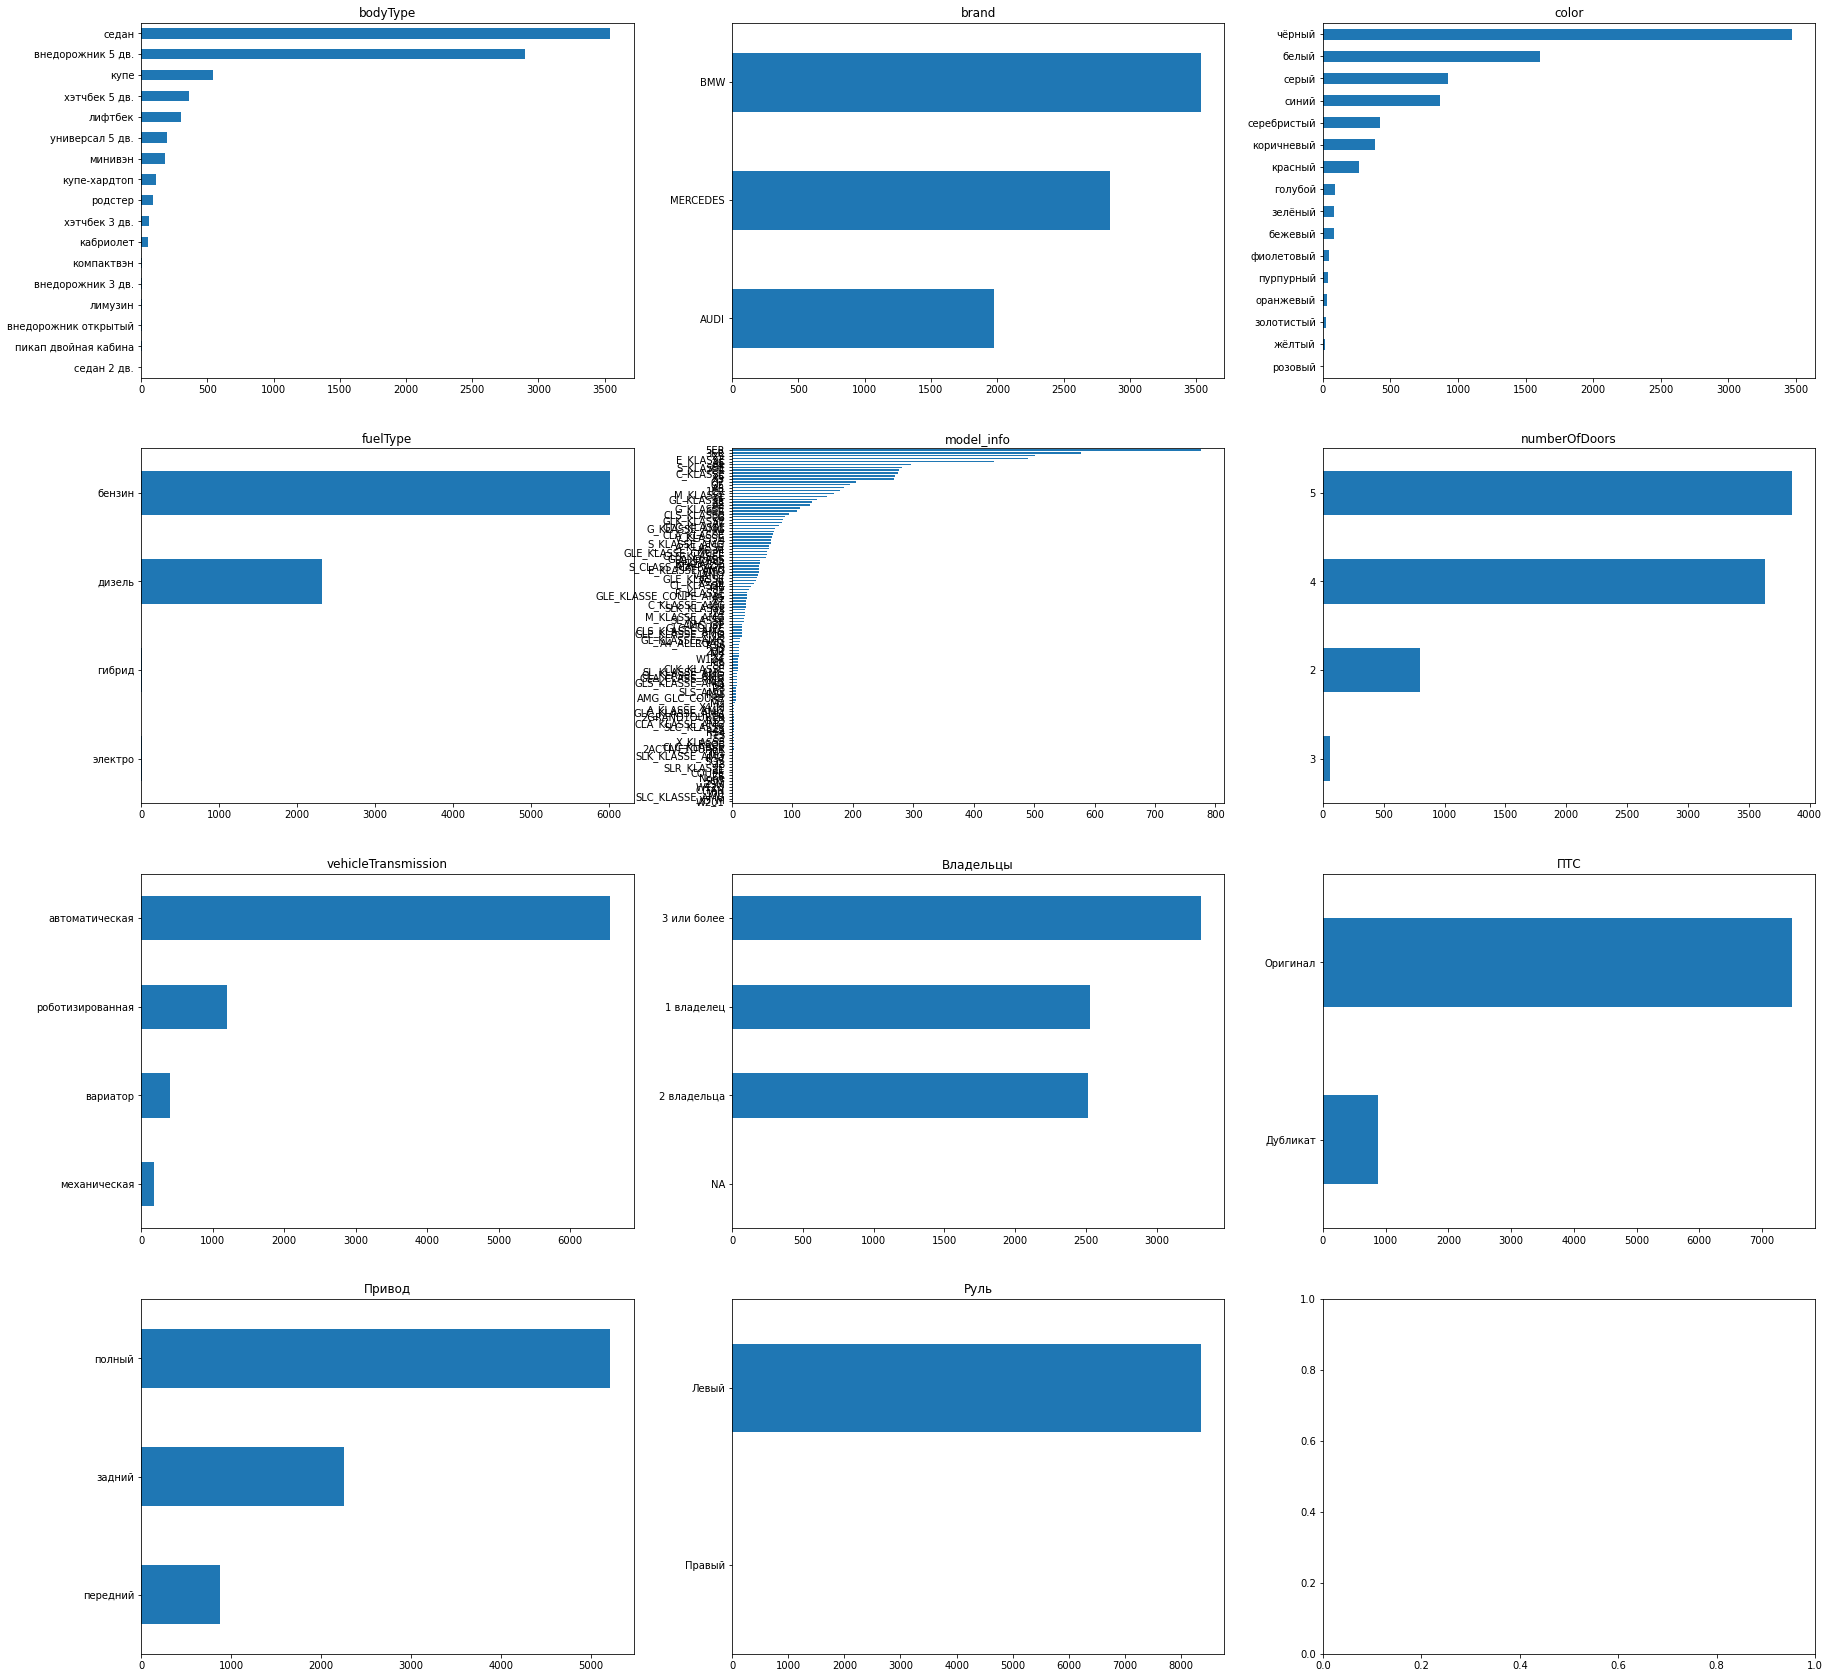

In [13]:
n = len(cat_cols)
col_num = 3
fig, axes = plt.subplots(int(np.ceil(n/col_num)), col_num, figsize = (30,30))
i = 0
for col in cat_cols:
    ax = axes[int(np.floor(i / col_num)), i % col_num]
    data[col].fillna('NA').value_counts().sort_values().plot(kind = 'barh', ax = ax, title = col)
    i += 1

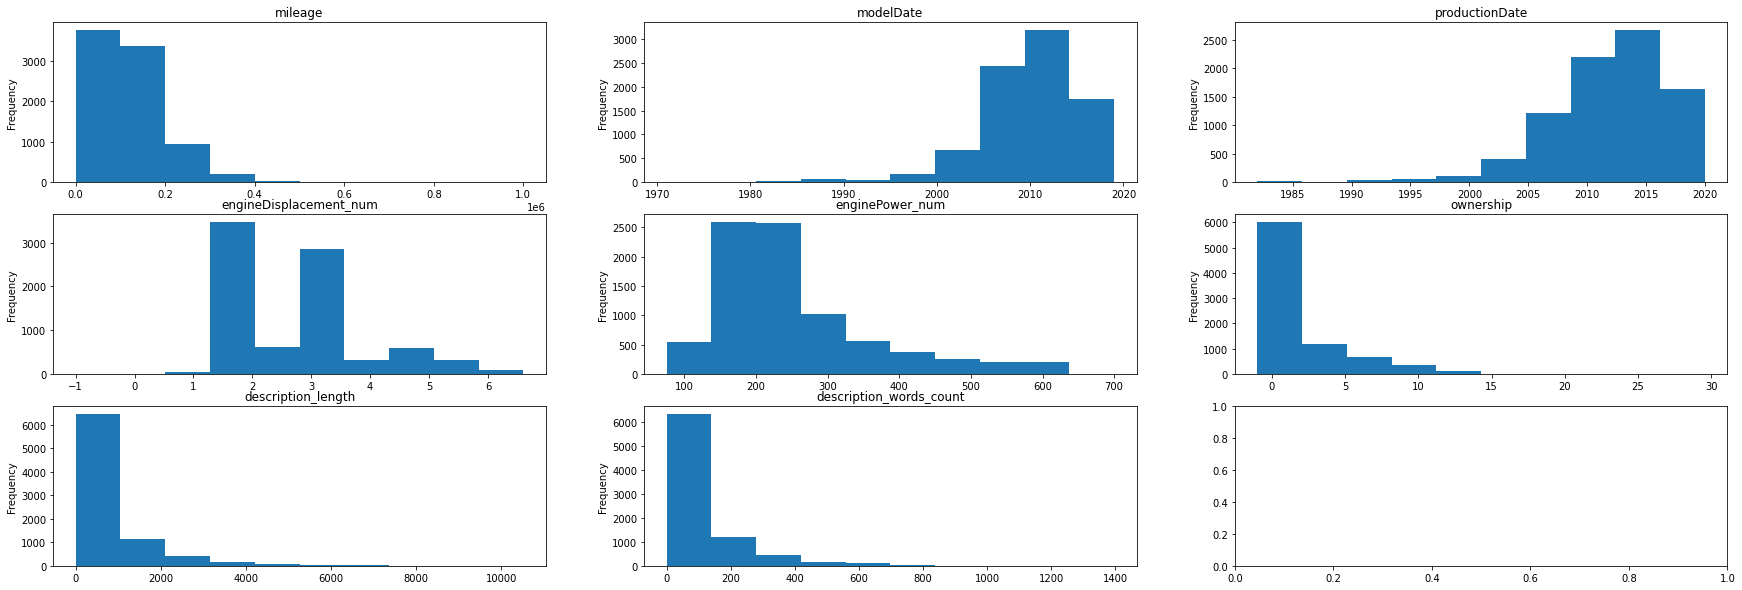

In [14]:
n = len(num_cols)
col_num = 3
fig, axes = plt.subplots(int(np.ceil(n/col_num)), col_num, figsize = (30,10))
i = 0
for col in num_cols:
    ax = axes[int(np.floor(i / col_num)), i % col_num]
    data[col].plot(kind = 'hist', ax = ax, title = col)
    i += 1

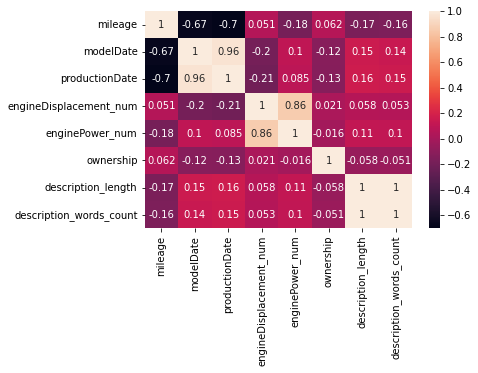

In [15]:
sns.heatmap(data[num_cols].corr(), annot=True);

In [16]:
#Удалим фичи с повышенной корреляцией
num_cols = [x for x in num_cols if x not in ['description_words_count']] #'productionDate',

## NLP

In [17]:
max_tokens = 1000
embedding_dim = 128

In [18]:
# Используем train/valid split из CV-ноутбука
train = data[(data['sample'] == 1) & (data['train'] == 1)].fillna(-1)
train_target = data[(data['sample'] == 1) & (data['train'] == 1)]['log_price']
valid = data[(data['sample'] == 1) & (data['train'] == 0)].fillna(-1)
valid_target = data[(data['sample'] == 1) & (data['train'] == 0)]['log_price']

In [19]:
vectorize_layer = layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_tokens, 
    output_sequence_length=1000
)

vectorize_layer.adapt(data['description_norm'])

2021-12-19 19:03:06.365554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:03:06.366439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:03:06.367079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:03:06.367976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:03:06.368648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [20]:
[x for x in vectorize_layer.get_vocabulary() if 'авто' in x]

['автомобил',
 'автомоб',
 'автомобиля',
 'автоматическ',
 'автомобиль',
 'авто',
 'автомобилей',
 'автосалон',
 'автокресел',
 'автокред',
 'автокредит',
 'автомобиле',
 'автодоводчик',
 'автодом',
 'автомобили',
 'памавтотрейд']

In [21]:
train_v = vectorize_layer(train['description'])
valid_v = vectorize_layer(valid['description'])

In [22]:
# An integer input for vocab indices.
inputs = layers.Input(shape=(None,), dtype="int64", name = 'Input')

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_tokens, embedding_dim, name = 'Embedding')(inputs)

# Conv1D + global max pooling
#x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3, name = 'Conv1D')(x)
#x = layers.Dropout(0.05, name = 'Dropout_1')(x)
#x = layers.Conv1D(64, 7, padding="valid", activation="relu", strides=3, name = 'Conv1D_2')(x)
#x = layers.Conv1D(32, 7, padding="valid", activation="relu", strides=3, name = 'Conv1D_3')(x)
#x = layers.GlobalMaxPooling1D(name = 'GlobalMaxPooling1D')(x)
x = layers.GlobalAveragePooling1D(name = 'GlobalAveragePooling1D')(x)

# LSTM
# x = layers.Bidirectional(layers.LSTM(embedding_dim))
# x = layers.LSTM(3, name = 'LSTM')(x)

# We add a vanilla hidden layer:
# x = layers.Dense(embedding_dim, activation="relu", name = 'Dense')(x)
#x = layers.Dropout(0.5, name = 'Dropout_2')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, name="Prediction")(x)

nlp_model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
nlp_model.compile(loss="mape", optimizer="adam", metrics=["mape"])

In [23]:
nlp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
Embedding (Embedding)        (None, None, 128)         128000    
_________________________________________________________________
GlobalAveragePooling1D (Glob (None, 128)               0         
_________________________________________________________________
Prediction (Dense)           (None, 1)                 129       
Total params: 128,129
Trainable params: 128,129
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 100

# Fit the model using the train and valid datasets.
history = nlp_model.fit(x = train_v, y = train_target, validation_data=(valid_v, valid_target), epochs=epochs, 
                        callbacks = [keras.callbacks.EarlyStopping(monitor='val_mape',patience=10,verbose=1,restore_best_weights=True)]
                       )

Epoch 1/100
147/147 [==============================] - 2s 6ms/step - loss: 83.3937 - mape: 83.3937 - val_loss: 52.7738 - val_mape: 52.7738
Epoch 2/100
147/147 [==============================] - 1s 5ms/step - loss: 15.2361 - mape: 15.2361 - val_loss: 3.9870 - val_mape: 3.9870
Epoch 3/100
147/147 [==============================] - 1s 5ms/step - loss: 4.0770 - mape: 4.0770 - val_loss: 3.8914 - val_mape: 3.8914
Epoch 4/100
147/147 [==============================] - 1s 5ms/step - loss: 4.0277 - mape: 4.0277 - val_loss: 3.8639 - val_mape: 3.8639
Epoch 5/100
147/147 [==============================] - 1s 5ms/step - loss: 3.9926 - mape: 3.9926 - val_loss: 3.8468 - val_mape: 3.8468
Epoch 6/100
147/147 [==============================] - 1s 5ms/step - loss: 3.9388 - mape: 3.9388 - val_loss: 3.7896 - val_mape: 3.7896
Epoch 7/100
147/147 [==============================] - 1s 6ms/step - loss: 3.9195 - mape: 3.9195 - val_loss: 3.7652 - val_mape: 3.7652
Epoch 8/100
147/147 [============================

(2.5, 4.5)

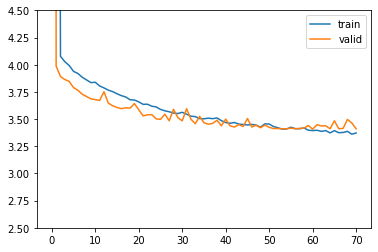

In [25]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.legend(['train','valid'])
plt.ylim((2.5,4.5))

In [26]:
train['nlp_pred'] = nlp_model.predict(train_v).reshape(-1)
valid['nlp_pred'] = nlp_model.predict(valid_v).reshape(-1)

In [27]:
print('Train MAPE:', mape(np.exp(train_target),np.exp(train['nlp_pred'])))
print('Valid MAPE:', mape(np.exp(valid_target),np.exp(valid['nlp_pred'])))

Train MAPE: 49.63051228132623
Valid MAPE: 49.57555805785006


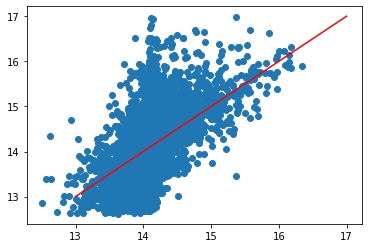

In [28]:
plt.scatter(train['nlp_pred'],train_target)
plt.plot([13,17],[13,17],'r');

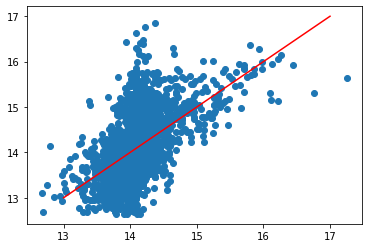

In [29]:
plt.scatter(valid['nlp_pred'],valid_target)
plt.plot([13,17],[13,17],'r');

## Boosting

In [30]:
feats = cat_cols + num_cols# + ['nlp_pred']
boost_model = CatBoostRegressor(iterations = 5000, verbose = False, cat_features = cat_cols, min_child_samples = 500)
boost_model.fit(train[feats], train_target, eval_set = (valid[feats], valid_target), use_best_model = True)
train['boost_pred'] = boost_model.predict(train[feats])
valid['boost_pred'] = boost_model.predict(valid[feats])
print('Best iteration:', boost_model.best_iteration_)
print('Train MAPE:', mape(np.exp(train_target),np.exp(train['boost_pred'])))
print('Valid MAPE:', mape(np.exp(valid_target),np.exp(valid['boost_pred'])))

Best iteration: 4994
Train MAPE: 8.06661604443895
Valid MAPE: 11.725185082467913


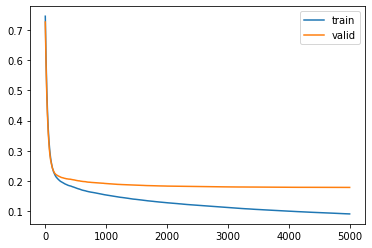

In [31]:
plt.plot(boost_model.evals_result_['learn']['RMSE'])
plt.plot(boost_model.evals_result_['validation']['RMSE'])
plt.legend(['train','valid']);

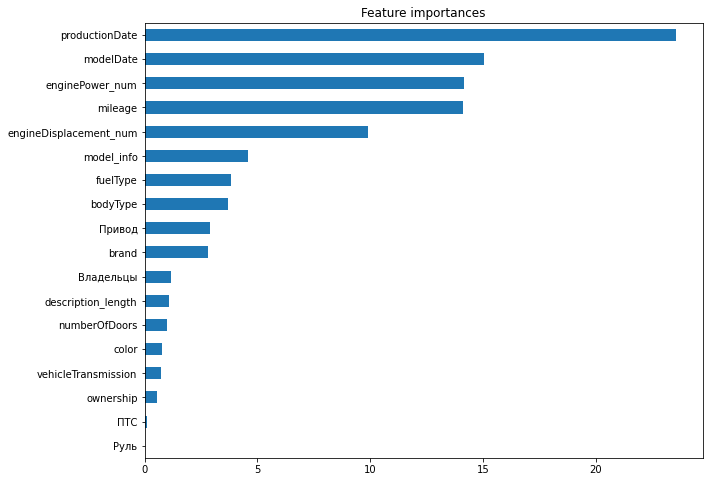

In [32]:
pd.Series(boost_model.feature_importances_, index = feats).nlargest(40).sort_values().plot(kind = 'barh', title = 'Feature importances', figsize = (10,8));

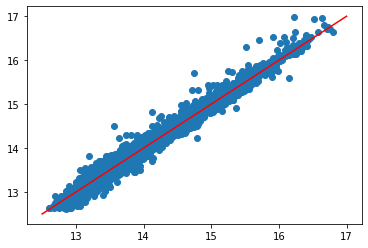

In [33]:
plt.scatter(train['boost_pred'],train_target)
plt.plot([12.5,17],[12.5,17],'r');

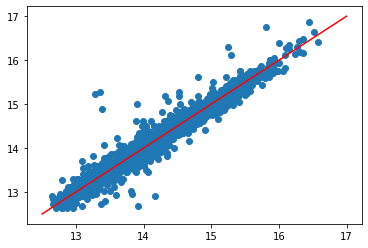

In [34]:
plt.scatter(valid['boost_pred'],valid_target)
plt.plot([12.5,17],[12.5,17],'r');

## Blending

In [35]:
train[['boost_pred','nlp_pred','CV_prediction']].corr()

,boost_pred,nlp_pred,CV_prediction
boost_pred,1.000000,0.579426,0.900611
nlp_pred,0.579426,1.000000,0.560878
CV_prediction,0.900611,0.560878,1.000000


In [36]:
# Прогноз языковой модели оказывается незначимым в интегральной модели
def f(a,x,y):
    return mape(np.exp(y),np.exp(a[0]*x['boost_pred'] + a[1]*x['nlp_pred'] + a[2]*x['CV_prediction']))

int_model = minimize(lambda a: f(a,train,train_target),[1,0,0])
int_model

      fun: 7.889680452952646
 hess_inv: array([[ 4.07797336e-02,  6.18189753e-05, -4.03440556e-02],
       [ 6.18189753e-05,  2.78506605e-07, -6.09095378e-05],
       [-4.03440556e-02, -6.09095378e-05,  3.99162969e-02]])
      jac: array([0.06468546, 0.2236684 , 0.05274856])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 264
      nit: 12
     njev: 63
   status: 2
  success: False
        x: array([ 0.95306215, -0.00973008,  0.0559651 ])

In [37]:
# Занулим ее вклад
def f(a,x,y):
    return mape(np.exp(y),np.exp(a[0]*x['boost_pred'] + a[1]*x['nlp_pred']*0 + a[2]*x['CV_prediction']))

int_model = minimize(lambda a: f(a,train,train_target),[1,0,0])
int_model

      fun: 7.903227134481443
 hess_inv: array([[ 0.00197132,  0.        , -0.00192308],
       [ 0.        ,  1.        ,  0.        ],
       [-0.00192308,  0.        ,  0.00187665]])
      jac: array([0.25493473, 0.        , 0.26546019])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 183
      nit: 9
     njev: 44
   status: 2
  success: False
        x: array([0.95025274, 0.        , 0.04910797])

In [38]:
print('Train MAPE:',f(int_model.x,train,train_target))
print('Valid MAPE:',f(int_model.x,valid,valid_target))

Train MAPE: 7.903227134481443
Valid MAPE: 11.460903513874678


## Submission

In [39]:
pd.read_csv(input_path + 'sample_submission.csv')

,sell_id,price
0,1099427284,0
1,1096405886,0
2,1100195294,0
3,1099827282,0
4,1100076198,0
...,...,...
1666,1099414488,0
1667,1099277058,0
1668,1098773964,0
1669,1098835932,0


In [40]:
tst = data[data['sample'] == 0].fillna(-1)
tst['nlp_pred'] = nlp_model.predict(vectorize_layer(tst['description'])).reshape(-1)
tst['boost_pred'] = boost_model.predict(tst[feats])
tst['price'] = np.exp(int_model.x[0]*tst['boost_pred'] + int_model.x[1]*tst['nlp_pred'] + int_model.x[2]*tst['CV_prediction'])
submission = test[['sell_id']]
submission['price'] = tst['price']
submission.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
